In [132]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from itertools import chain
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
import torch.optim as optim
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
import time
import os

In [133]:
start_x = np.random.choice([0, 2])
x = np.random.randint(start_x, 9)
y = np.random.randint(0 if start_x == 2 else 2, 9)
print(x, y)

2 5


In [134]:
# set seed of all polssible random number generators
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# enable CUDA_LAUNCH_BLOCKING=1 to debug cuda
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [135]:
def read_data_frame():
    df = pd.read_csv("data/all_data.csv")
    episodes = df.groupby("Episode")
    episode_data = {}
    for episode, data in episodes:
        episode_data[episode] = [
            [row["X"], row["Y"], row["Action"], row["Reward"]]
            for index, row in data.iterrows()
        ]
    return episode_data


episode_data = [episode for episode in read_data_frame().values()]

In [136]:
len(episode_data)

11865

In [6]:
# shuffle the data and split it into training and testing
np.random.shuffle(episode_data)
train_data = episode_data[: int(len(episode_data) * 0.8)]
test_data = episode_data[int(len(episode_data) * 0.8) :]

In [7]:
class CFG:
    block_size = 512
    start_token = 0
    max_grid_size = 50
    padding_token = 1
    end_token = 2
    batch_size = 64
    learning_rate = 3e-4
    state_min, state_max = 0, 9  # Adjust based on your environment
    state_bins = 10
    reward_min, reward_max = -1, 1  # Adjust based on your environment
    reward_bins = 20
    action_dim = 5
    n_embd = 128
    n_head = 2
    n_layer = 3
    dropout = 0.2
    vocab_size = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class Tokenizer:
    mapper = dict(
        {
            CFG.start_token: CFG.start_token,
            CFG.padding_token: CFG.padding_token,
            CFG.end_token: CFG.end_token,
        }
    )

    vocab_size = CFG.max_grid_size * 2 + CFG.action_dim + 2 + 3
    offset = 3
    coordinate_demention_size = 100  # max grid size
    token_counter = 3

    def __init__(self, cfg: CFG):
        self.cfg = cfg

    # gets one unicode number. It should check if the unicode number is already in the mapper. If not, it should add it. Returns the number.
    def get_tokenized_unicode(self, x):
        if x not in self.mapper:
            self.mapper[x] = self.token_counter
            self.token_counter += 1
        return self.mapper[x]

    def encode(self, x: np.array):
        x = np.array(x)
        tokens = []
        for i in range(0, len(x)):
            step = np.array(x[i])
            tokens.extend(
                [
                    step[0] + self.offset,
                    step[1] + self.offset + CFG.max_grid_size,
                    step[2] + self.offset + CFG.max_grid_size * 2,
                    step[3] + self.offset + CFG.max_grid_size * 2 + CFG.action_dim,
                ]
            )
        return [CFG.start_token] + tokens + [CFG.end_token]

    def pad(self, x):
        return x + [CFG.padding_token] * (CFG.block_size - len(x))

    def __call__(self, x):
        encoded = self.encode(x)
        padded = self.pad(encoded)
        if len(padded) != CFG.block_size:
            print("padding error")
        return padded

In [9]:
tokenizer = Tokenizer(CFG)

In [10]:
class A3CDataset(torch.utils.data.Dataset):
    def __init__(self, global_history, tokenizer):
        self.global_history = global_history
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.global_history)

    def crop(self, arr):
        if len(arr) > CFG.block_size // 4:
            # make sequence CFG.block_size wize by randomly cropping the sequence
            start_index = np.random.randint(0, len(arr) - CFG.block_size // 4)
            arr = arr[start_index : start_index + CFG.block_size // 4]

        take_first = np.random.randint(2, len(arr))
        target = arr[-1]
        arr = arr[: take_first - 1]
        return arr, target

    def __getitem__(self, idx):
        learning_history = self.global_history[idx]

        learning_history, target = self.crop(learning_history)

        tokenized = self.tokenizer(learning_history)
        tensor = torch.tensor(tokenized, dtype=torch.long)
        action = torch.tensor(target[2], dtype=torch.long)
        if tensor.shape[0] > CFG.block_size:
            print(tensor.shape)

        return tensor, action

In [11]:
dataset = A3CDataset(episode_data, tokenizer)

In [10]:
# loader = DataLoader(dataset, batch_size=CFG.batch_size)

# for i, batch in enumerate(loader):
#     print(i)
#     print(batch[0].shape)

In [11]:
len(train_data)

3219

In [12]:
len(A3CDataset(train_data, tokenizer=tokenizer))

3219

In [12]:
train_data_loader = DataLoader(
    A3CDataset(train_data, tokenizer=tokenizer),
    batch_size=CFG.batch_size,
    shuffle=False,
)
test_data_loader = DataLoader(
    A3CDataset(test_data, tokenizer=tokenizer), batch_size=CFG.batch_size, shuffle=False
)

In [14]:
print(f"sample: {next(iter(train_data_loader))}")

sample: [tensor([[ 0,  7, 56,  ...,  1,  1,  1],
        [ 0,  6, 57,  ...,  1,  1,  1],
        [ 0,  7, 56,  ...,  1,  1,  1],
        ...,
        [ 0,  6, 57,  ...,  1,  1,  1],
        [ 0,  7, 56,  ...,  1,  1,  1],
        [ 0,  7, 56,  ...,  1,  1,  1]]), tensor([2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2,
        2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0,
        2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2])]


In [15]:
tokenizer.mapper

{0: 0, 1: 1, 2: 2}

### Find vocabulary size base on all data

In [16]:
all_data_loader = DataLoader(
    A3CDataset(episode_data, tokenizer=tokenizer),
    batch_size=CFG.batch_size,
    shuffle=False,
)

In [17]:
for x, y in all_data_loader:
    # noop
    a = 2

print(f"Vocab size: {CFG.vocab_size}")
CFG.vocab_size = tokenizer.vocab_size

Vocab size: 0


### NANO

In [13]:
# hyperparameters
# batch_size = 64  # how many independent sequences will we process in parallel?
# max_iters = 5000
# eval_interval = 500
# learning_rate = 3e-4
# device = "cuda" if torch.cuda.is_available() else "cpu"
# eval_iters = 200
# n_embd = 384
# n_head = 8
# n_layer = 8
# dropout = 0.2


class Head(nn.Module):
    """one head of self-attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(CFG.n_embd, head_size, bias=False)
        self.query = nn.Linear(CFG.n_embd, head_size, bias=False)
        self.value = nn.Linear(CFG.n_embd, head_size, bias=False)
        self.register_buffer(
            "tril", torch.tril(torch.ones(CFG.block_size, CFG.block_size))
        )

        self.dropout = nn.Dropout(CFG.dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B, T, C = x.shape
        k = self.key(x)  # (B,T,hs)
        q = self.query(x)  # (B,T,hs)
        # compute attention scores ("affinities")
        wei = (
            q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5
        )  # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))  # (B, T, T)
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x)  # (B,T,hs)
        out = wei @ v  # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out


class MultiHeadAttention(nn.Module):
    """multiple heads of self-attention in parallel"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, CFG.n_embd)
        self.dropout = nn.Dropout(CFG.dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedFoward(nn.Module):
    """a simple linear layer followed by a non-linearity"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(CFG.dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """Transformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(CFG.dropout),
        )
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(CFG.vocab_size, CFG.n_embd)
        self.position_embedding_table = nn.Embedding(CFG.block_size, CFG.n_embd)
        self.blocks = nn.Sequential(
            *[Block(CFG.n_embd, n_head=CFG.n_head) for _ in range(CFG.n_layer)]
        )
        self.ln_f = nn.LayerNorm(CFG.n_embd)  # final layer norm
        self.lm_head = nn.Linear(CFG.n_embd, CFG.action_dim)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx)
        # tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(
            torch.arange(T, device=CFG.device)
        )  # (T,C)
        x = tok_emb + pos_emb  # (B,T,C)
        x = self.blocks(x)  # (B,T,C)
        x = self.ln_f(x)  # (B,T,C)
        logits = self.lm_head(x[:, -1, :])  # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            # B, T, C = logits.shape
            # logits = logits.view(B, C * T)
            # targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss


model = GPTLanguageModel()
m = model.to(CFG.device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters()) / 1e6, "M parameters")

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.learning_rate)

0.660101 M parameters


In [19]:
# tokenizer = ADTokenizer(CFG)

# train_data_loader = DataLoader(
#     A3CDataset(train_data, tokenizer=tokenizer),
#     batch_size=CFG.batch_size,
#     shuffle=True,
# )
# test_data_loader = DataLoader(
#     A3CDataset(test_data, tokenizer=tokenizer), batch_size=CFG.batch_size, shuffle=False
# )

# CFG.vocab_size = tokenizer.vocab_size

In [19]:
EPOCHS = 10
linear_schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lambda i: min(1.0, i / (EPOCHS * len(train_data_loader)))
)
# tensorboard pytorch logging


if True:
    writer = SummaryWriter()
    # training loop
    for i in range(EPOCHS):
        model.train()
        for j, (X, y) in tqdm(
            enumerate(train_data_loader),
            unit="batch",
            total=len(train_data_loader),
            desc=f"Epoch {i}",
        ):
            X = X.to(CFG.device)
            y = y.to(CFG.device)
            optimizer.zero_grad()
            logits, loss = model(X, y)
            writer.add_scalar("Loss/train", loss.item(), time.time())
            writer.add_scalar(
                "Learning rate", optimizer.param_groups[0]["lr"], time.time()
            )
            writer.add_scalar("Epoch", i, time.time())
            loss.backward()
            linear_schedule.step()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            total_correct = 0
            for i, (X, y) in tqdm(
                enumerate(test_data_loader),
                unit="batch",
                total=len(test_data_loader),
                desc=f"Epoch {i}",
            ):
                X = X.to(CFG.device)
                y = y.to(CFG.device)
                logits, loss = model(X, y)
                total_correct += (logits.argmax(1) == y).sum().item()
                writer.add_scalar("Loss/val", loss, time.time())
                writer.add_scalar("Epoch", i, time.time())
            writer.add_scalar(
                "Accuracy/val", total_correct / len(test_data_loader), time.time()
            )

    writer.close()

Epoch 0:   0%|          | 0/51 [00:00<?, ?batch/s]/home/lex/miniconda3/envs/airi/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Epoch 9: 100%|██████████| 13/13 [00:00<00:00, 86.07batch/s]


### Solution with Claude help

In [14]:
class ADTokenizer:
    def __init__(self, cfg):
        self.cfg = cfg
        self.state_bins = np.linspace(cfg.state_min, cfg.state_max, cfg.state_bins)
        self.reward_bins = np.linspace(cfg.reward_min, cfg.reward_max, cfg.reward_bins)
        self.vocab_size = (
            cfg.state_bins * 2 + cfg.action_dim + cfg.reward_bins + 3
        )  # +3 for start, end, and pad tokens

    def discretize(self, value, bins):
        return np.digitize(value, bins)

    def encode(self, x):
        tokens = []
        for state_x, state_y, action, reward in x:
            tokens.extend(
                [
                    self.discretize(state_x, self.state_bins) + 3,
                    self.discretize(state_y, self.state_bins) + self.cfg.state_bins + 3,
                    action + self.cfg.state_bins * 2 + 3,
                    self.discretize(reward, self.reward_bins)
                    + self.cfg.state_bins * 2
                    + self.cfg.action_dim
                    + 3,
                ]
            )
        return [self.cfg.start_token] + tokens + [self.cfg.end_token]

    def pad(self, x):
        return x + [self.cfg.padding_token] * (self.cfg.block_size - len(x))

    def __call__(self, x):
        return self.pad(self.encode(x))


# class A3CDataset(Dataset):
#     def __init__(self, global_history, tokenizer, use_crop=True):
#         self.global_history = global_history
#         self.tokenizer = tokenizer
#         self.use_crop = use_crop

#     def __len__(self):
#         return len(self.global_history)

#     def crop(self, arr):
#         if len(arr) > self.tokenizer.cfg.block_size // 4:
#             arr = arr[: self.tokenizer.cfg.block_size // 4]
#         take_first = np.random.randint(2, len(arr))
#         target = arr[-1]
#         arr = arr[: take_first - 1]
#         return arr, target

#     def __getitem__(self, idx):
#         learning_history = self.global_history[idx]
#         if self.use_crop:
#             learning_history, target = self.crop(learning_history)
#         learning_history = learning_history[: len(learning_history) - 1]
#         # target = learning_history[-1]
#         tokenized = self.tokenizer(learning_history)
#         tensor = torch.tensor(tokenized)
#         action = torch.tensor(target[2])
#         return tensor, action


class ADTransformer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.token_embedding = nn.Embedding(cfg.vocab_size, cfg.n_embd)
        self.position_embedding = nn.Embedding(cfg.block_size, cfg.n_embd)
        self.blocks = nn.Sequential(
            *[Block(cfg.n_embd, cfg.n_head) for _ in range(cfg.n_layer)]
        )
        self.ln_f = nn.LayerNorm(cfg.n_embd)
        self.action_head = nn.Linear(cfg.n_embd, cfg.action_dim)

    def forward(self, idx):
        b, t = idx.size()
        tok_emb = self.token_embedding(idx)
        pos_emb = self.position_embedding(torch.arange(t, device=idx.device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        action_logits = self.action_head(
            x[:, -1, :]
        )  # Only predict for the last position

        # action_logits = self.action_head(x)  # Only predict for the last position

        return action_logits

    def predict_action(self, context):
        action_logits = self(context)
        return torch.argmax(action_logits, dim=-1)

In [15]:
# tokenizer = ADTokenizer(CFG)

train_data_loader = DataLoader(
    A3CDataset(train_data, tokenizer=tokenizer),
    batch_size=CFG.batch_size,
    shuffle=True,
)

test_data_loader = DataLoader(
    A3CDataset(test_data, tokenizer=tokenizer), batch_size=CFG.batch_size, shuffle=False
)

# CFG.vocab_size = tokenizer.vocab_size
CFG.vocab_size = tokenizer.vocab_size

model = ADTransformer(CFG).to(CFG.device)

In [54]:
tokenizer.vocab_size

110

In [16]:
EPOCHS = 10
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=EPOCHS * len(train_data_loader)
)

writer = SummaryWriter()

for epoch in range(EPOCHS):
    model.train()
    for j, (X, y) in tqdm(
        enumerate(train_data_loader),
        total=len(train_data_loader),
        desc=f"Epoch {epoch}",
    ):
        X, y = X.to(CFG.device), y.to(CFG.device)
        optimizer.zero_grad()
        logits = model(X)

        # B, T, C = logits.shape
        # logits = logits.view(B, C * T)
        # targets = targets.view(B * T)
        loss = F.cross_entropy(logits, y)

        # loss = F.cross_entropy(logits, y)
        writer.add_scalar("Loss/train", loss.item(), epoch * len(train_data_loader) + j)
        writer.add_scalar(
            "Learning rate",
            scheduler.get_last_lr()[0],
            epoch * len(train_data_loader) + j,
        )
        loss.backward()
        optimizer.step()
        scheduler.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in test_data_loader:
            X, y = X.to(CFG.device), y.to(CFG.device)
            logits = model(X)
            # B, T, C = logits.shape
            # logits = logits.view(B, C * T)
            val_loss += F.cross_entropy(logits, y).item()
    val_loss /= len(test_data_loader)
    writer.add_scalar("Loss/val", val_loss, epoch)

    print(f"Epoch {epoch}: Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

writer.close()

Epoch 0: 100%|██████████| 165/165 [00:06<00:00, 25.17it/s]


Epoch 0: Train Loss: 0.6232, Val Loss: 0.6634


Epoch 1: 100%|██████████| 165/165 [00:06<00:00, 26.45it/s]


Epoch 1: Train Loss: 0.8385, Val Loss: 0.6242


Epoch 2: 100%|██████████| 165/165 [00:06<00:00, 26.59it/s]


Epoch 2: Train Loss: 0.3502, Val Loss: 0.6284


Epoch 3: 100%|██████████| 165/165 [00:06<00:00, 26.27it/s]


Epoch 3: Train Loss: 0.6057, Val Loss: 0.6210


Epoch 4: 100%|██████████| 165/165 [00:06<00:00, 25.78it/s]


Epoch 4: Train Loss: 0.7102, Val Loss: 0.6201


Epoch 5: 100%|██████████| 165/165 [00:06<00:00, 25.49it/s]


Epoch 5: Train Loss: 0.5489, Val Loss: 0.6233


Epoch 6: 100%|██████████| 165/165 [00:06<00:00, 25.71it/s]


Epoch 6: Train Loss: 0.7933, Val Loss: 0.6145


Epoch 7: 100%|██████████| 165/165 [00:06<00:00, 26.29it/s]


Epoch 7: Train Loss: 0.4014, Val Loss: 0.6075


Epoch 8: 100%|██████████| 165/165 [00:06<00:00, 26.25it/s]


Epoch 8: Train Loss: 0.5569, Val Loss: 0.6022


Epoch 9: 100%|██████████| 165/165 [00:06<00:00, 25.40it/s]


Epoch 9: Train Loss: 0.3818, Val Loss: 0.6095


In [17]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X, y in test_data_loader:
        X, y = X.to(CFG.device), y.to(CFG.device)
        logits = model(X)
        # B, T, C = logits.shape
        # logits = logits.view(B, C * T)
        predicted = torch.argmax(logits, dim=1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.6650


In [18]:
# save the model
torch.save(model.state_dict(), "model.pth")
# model.load_state_dict(torch.load("model.pth"))

In [30]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

from dark_room import DarkRoom

env = DarkRoom()


def gpt_step(action_history, max_len=CFG.block_size // 8 - 1):
    if len(action_history) > max_len:
        action_history = action_history[-max_len:]
    tokenized = torch.tensor(
        [tokenizer(action_history)], dtype=torch.long, device="cpu"
    )
    logits = model(tokenized)
    action = torch.argmax(logits, dim=1).item()
    return action


def render_env(env, title, speepTime=0):
    # clear previous image
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.title(title)
    # plt.axis("off")
    plt.show()
    time.sleep(speepTime)

In [23]:
model = model.eval().cpu()

In [27]:
state = env.reset()
history = [[state[0], state[1], 0, 0]]

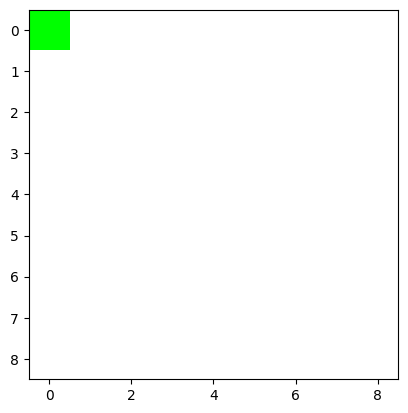

In [38]:
action = gpt_step(history)
state, reward, done = env.step(action)
history.append([state[0], state[1], action, reward])
render_env(env, "")

In [39]:
import numpy as np


context = []
returns = []
num_episodes = 100
mapper = {}

env = DarkRoom(size=15)

for episode in range(num_episodes):
    state = env.reset(use_random_agent_pos=False, agent_pos=[12, 8])
    if len(context) == 0:
        context = [[state[0], state[1], 0, 0]]
    done = False
    total_return = 0
    steps_per_episode = 0
    while not done:
        action = gpt_step(context)
        state, reward, done = env.step(action)
        context.append([state[0], state[1], action, reward])
        state, reward, done = env.step(action)
        total_return += reward
        steps_per_episode += 1
        render_env(env, episode)
    mapper[episode] = steps_per_episode
    returns.append(total_return)

KeyboardInterrupt: 

In [40]:
mapper

{0: 10,
 1: 14,
 2: 41,
 3: 17,
 4: 16,
 5: 55,
 6: 17,
 7: 52,
 8: 17,
 9: 31,
 10: 26,
 11: 18,
 12: 55}

In [93]:
from dark_room import DarkRoom
from time import sleep
from utils import print_grid


model = model.eval().cpu()
env = DarkRoom(size=14, goal=(0, 0))
state = env.reset()


action_history = [[4.0, 4.0, 0, 0]]
global_reward = 0


def make_iteration(state, global_reward):
    tokenized = torch.tensor([tokenizer(action_history)], dtype=torch.long)
    logits = model(tokenized)
    # B, T, C = logits.shape
    # logits = logits.view(B, C * T)
    action = torch.argmax(logits, dim=1).item()
    #     action = torch.softmax(policy[0], dim=-1).argmax().item()
    # action = Categorical(policy).sample().item()
    state, reward, done = env.step(action)

    action_history.append([state[0], state[1], action, reward])

    return state, global_reward + reward, done

In [94]:
action_history

[[4.0, 4.0, 0, 0]]

In [108]:
state, global_reward, done = make_iteration(state, global_reward)
print_grid(env.render())

Goal reached

[['G' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]


Test Accuracy: 0.7790


In [ ]:
### Training

Epoch 0:   0%|          | 0/51 [00:00<?, ?batch/s]../aten/src/ATen/native/cuda/Indexing.cu:1284: indexSelectLargeIndex: block: [526,0,0], thread: [96,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1284: indexSelectLargeIndex: block: [526,0,0], thread: [97,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1284: indexSelectLargeIndex: block: [526,0,0], thread: [98,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1284: indexSelectLargeIndex: block: [526,0,0], thread: [99,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1284: indexSelectLargeIndex: block: [526,0,0], thread: [100,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1284: indexSelectLargeIndex: block: [526,0,0], thread: [101,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/I

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [20]:
from dark_room import DarkRoom
from time import sleep

from utils import print_grid

model.eval()
env = DarkRoom(size=16)
state = env.reset()


action_history = [[4.0, 4.0, 0, 0]]
global_reward = 0


def make_iteration(state):
    tokenized = torch.tensor([tokenizer(action_history)], dtype=torch.long).to(
        CFG.device
    )
    policy = model(tokenized)
    action = torch.softmax(policy[0], dim=-1).argmax().item()
    # action = Categorical(policy).sample().item()
    state, reward, done = env.step(action)

    action_history.append([state[0], state[1], action, reward])

    return state, reward, done


# for i in range(1000):
#     state, reward, done = make_iteration(state)
#     sleep(0.1)
#     if done:
#         print(f"Goal reached in {i} steps")
#         print(f"Action history: {action_history}")
#         print_grid(env.render())
#         break

In [21]:
action_history

[[4.0, 4.0, 0, 0]]

In [48]:
state, reward, done = make_iteration(state)
print_grid(env.render())

Goal reached

[['G' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 

In [99]:
env.step(0)

([0, 2], -1, False)